<a href="https://colab.research.google.com/github/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/learn_to_compose_spatial_relations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How Neural Language Models Learn To Compose?

- Composing word sequence (words -> phrases)
- Composing different representations (fusion of modalities)

**Method:** 
- Generate descriptions based on their *acceptability scores* for any situation.
- Train a neural language model for these scene descriptions in show-tell scenario. 
- Reconstruct the spatial templates for any word composition based on the language model.
- Show that spatial templates can be learned for unseen word sequences inlcuding unseen single word usages. 

In [0]:
# we are going to need these libraries
%matplotlib inline

import numpy as np
from scipy.stats import mstats, spearmanr, pearsonr
import matplotlib.pyplot as plt
from itertools import product, combinations
from IPython.core.display import Markdown

## library
# If you use GPU, selection it first:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Keras library
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, LSTM, Embedding, Masking, Dropout
from tensorflow.keras.layers import Input, Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import TimeDistributed, Concatenate
from tensorflow.keras import backend as K

## Acceptabilities as Representation of Spatial Relations 

In [0]:
# Spatial templates from human judgments on 10 spatial relations: 
"""
@article{logan1996computational,
  title={A computational analysis of the apprehension of spatial relations.},
  author={Logan, Gordon D and Sadler, Daniel D},
  year={1996},
  publisher={The MIT Press}
}
"""
#templates = np.load('logan_sadler_1996.npy', allow_pickle=True)[None][0]
templates = {
 'above': np.array([[7.  , 7.66, 8.1 , 8.61, 8.19, 7.32, 7.66],
        [6.69, 6.56, 7.66, 8.55, 7.13, 7.16, 6.88],
        [5.63, 6.41, 7.09, 8.53, 7.35, 6.74, 5.53],
        [1.94, 2.16, 1.88, 0.  , 1.97, 1.88, 2.  ],
        [1.94, 1.78, 1.66, 1.13, 1.63, 2.41, 1.66],
        [1.81, 1.94, 1.42, 1.03, 1.5 , 1.84, 1.58],
        [1.44, 1.38, 1.34, 1.19, 1.34, 2.08, 1.44]], ),
 'below': np.array([[1.5 , 1.66, 1.29, 1.03, 1.33, 1.75, 1.59],
        [1.71, 2.09, 1.4 , 1.31, 1.44, 1.66, 1.45],
        [1.94, 2.09, 1.65, 1.72, 1.88, 2.39, 2.  ],
        [2.16, 2.29, 2.03, 0.  , 2.41, 1.94, 2.  ],
        [5.66, 6.31, 6.94, 8.16, 6.94, 6.  , 5.81],
        [6.  , 7.09, 7.74, 8.71, 7.78, 7.1 , 6.88],
        [7.42, 5.  , 6.88, 8.4 , 7.72, 7.71, 7.53]], ),
 'over': np.array([[8.84, 7.65, 8.1 , 8.9 , 7.59, 7.38, 7.1 ],
        [6.75, 6.94, 7.19, 8.29, 7.45, 7.32, 8.41],
        [5.69, 5.97, 7.07, 8.42, 7.19, 6.38, 5.58],
        [1.91, 2.19, 2.09, 0.  , 2.13, 1.94, 2.25],
        [2.28, 1.91, 1.71, 1.28, 1.97, 2.09, 2.  ],
        [1.69, 2.  , 1.28, 1.45, 2.19, 1.69, 1.66],
        [1.52, 1.59, 1.52, 1.2 , 1.28, 1.66, 1.66]], ),
 'under': np.array([[1.81, 1.94, 1.38, 1.39, 1.59, 1.72, 1.47],
        [1.83, 1.53, 2.03, 1.41, 1.44, 1.63, 1.84],
        [1.77, 1.78, 1.63, 1.44, 1.59, 1.68, 2.19],
        [2.06, 2.22, 1.91, 0.  , 2.25, 2.39, 2.  ],
        [5.71, 5.66, 6.75, 8.23, 6.84, 5.88, 5.84],
        [6.59, 7.  , 7.59, 7.45, 7.38, 6.5 , 6.1 ],
        [7.22, 7.55, 7.9 , 8.72, 7.78, 7.74, 7.03]], ),
 'next_to': np.array([[2.65, 2.06, 2.1 , 2.03, 2.29, 1.94, 1.7 ],
        [2.84, 3.32, 3.31, 3.91, 3.35, 3.34, 2.94],
        [4.06, 4.75, 5.9 , 6.7 , 6.57, 4.72, 3.87],
        [4.52, 6.  , 8.17, 0.  , 8.39, 6.69, 4.88],
        [3.56, 4.59, 6.59, 6.19, 5.91, 5.38, 4.13],
        [2.94, 3.58, 3.66, 4.06, 4.  , 3.32, 3.06],
        [2.37, 2.06, 2.53, 2.31, 1.81, 2.  , 1.69]], ),
 'away_from': np.array([[7.38, 7.94, 7.45, 7.74, 7.72, 8.1 , 8.44],
        [7.41, 6.84, 5.74, 5.16, 5.69, 6.72, 7.22],
        [5.9 , 4.75, 2.94, 2.91, 2.78, 5.13, 6.47],
        [5.35, 4.38, 2.13, 0.  , 1.88, 4.58, 6.25],
        [6.32, 4.81, 3.09, 2.5 , 3.44, 5.41, 6.45],
        [7.28, 6.09, 5.34, 4.97, 5.41, 5.75, 7.66],
        [8.1 , 7.5 , 7.58, 7.63, 7.44, 7.83, 8.26]], ),
 'near_to': np.array([[1.74, 1.9 , 2.84, 3.16, 2.34, 1.81, 2.13],
        [2.61, 3.84, 4.66, 4.97, 4.9 , 3.56, 3.26],
        [4.06, 5.56, 7.55, 7.97, 7.29, 4.8 , 3.91],
        [4.47, 5.91, 8.52, 0.  , 7.9 , 6.13, 4.63],
        [3.47, 4.81, 6.94, 7.56, 7.31, 5.59, 3.63],
        [3.25, 4.03, 4.5 , 4.78, 4.41, 3.47, 3.1 ],
        [1.84, 2.23, 2.03, 3.06, 2.53, 2.13, 2.  ]], ),
 'far_from': np.array([[7.48, 7.94, 7.56, 7.42, 7.38, 7.88, 8.48],
        [6.56, 5.78, 5.41, 5.41, 5.19, 5.38, 7.03],
        [5.69, 4.03, 2.28, 1.78, 2.84, 4.13, 6.06],
        [5.59, 3.44, 1.87, 0.  , 1.66, 4.22, 5.71],
        [6.9 , 4.56, 2.28, 1.81, 2.31, 4.09, 6.13],
        [7.09, 6.03, 4.88, 5.19, 5.16, 6.  , 7.42],
        [7.68, 7.77, 7.58, 7.13, 7.47, 7.78, 8.41]], ),
 'left_of': np.array([[6.56, 5.65, 5.28, 2.56, 2.13, 1.88, 1.66],
        [7.  , 6.06, 5.39, 2.25, 2.16, 1.53, 1.8 ],
        [7.13, 6.52, 6.34, 2.31, 2.47, 1.94, 2.1 ],
        [8.35, 7.83, 8.06, 0.  , 1.1 , 1.59, 1.94],
        [6.84, 6.39, 6.65, 2.16, 2.03, 2.1 , 1.41],
        [6.03, 6.23, 5.63, 2.48, 1.9 , 2.22, 1.59],
        [6.16, 5.77, 4.94, 1.9 , 1.94, 1.94, 2.03]], ),
 'right_of': np.array([[1.72, 1.97, 1.66, 2.22, 5.5 , 6.45, 6.59],
        [1.9 , 2.  , 2.  , 2.28, 5.78, 6.52, 7.06],
        [1.33, 1.63, 2.13, 2.39, 6.39, 6.84, 7.03],
        [1.09, 1.35, 1.38, 0.  , 8.35, 8.52, 8.71],
        [1.69, 1.74, 2.25, 2.09, 6.03, 6.81, 7.5 ],
        [1.66, 1.94, 1.81, 2.03, 5.59, 6.72, 6.63],
        [1.5 , 1.72, 1.94, 1.87, 5.47, 6.13, 6.44]], )
}

# min-max normalisation of the template 
def normalize(x, x_min=None, x_max=None):
    if x_min is None:
        x_min = x.min() 
    if x_max is None:
        x_max = x.max()
    out = (x - x_min) / (x_max - x_min)
    out[3,3] = 0
    
    return out

for w in templates:
    templates[w] = normalize(templates[w], x_min=1, x_max=9)

### Visualize all generated templates

In [0]:
! mkdir plots

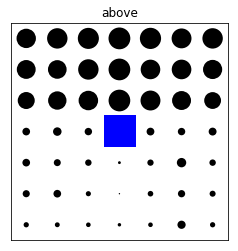

In [8]:
# plotting funciton for any 7x7 template
def plot_template(template, title, savefig=False):
    landmark = np.zeros([7,7,4])
    landmark[3,3] = np.array([0., 0., 1., 1.])
    
    sizes = template * 500
    
    points = np.array([
        [i, j, sizes[j, i]]
        for i in range(7)
        for j in range(7)
    ])

    plt.title(title)
    plt.scatter(x=points[:, 0], y=points[:, 1], s=points[:, 2], c="black", marker='o', linewidths=0)
    plt.imshow(landmark)
    plt.xticks([])
    plt.yticks([])
    
    if savefig:
        img_path = "plots/" + title.replace(" ", "_") + ".png"
        plt.savefig(img_path, bbox_inches = 'tight', pad_inches = 0)
        plt.clf()
        return img_path
    else:
        plt.show()
        return 

plot_template(templates["above"], "above")

In [0]:
def generate_situaiton(i, j):
    situation = np.zeros([7, 7])
    situation[i, j] = 1
    return situation

# generate images for visualisation
ploted_situaitons = [
    ("situ_{0}x{1}".format(i+1, j+1), plot_template(generate_situaiton(i, j), title="situ_{0}x{1}".format(i+1, j+1), savefig=True))
    for i in range(7)
    for j in range(7)
]


def to_md(path):
    return "![]({0})".format(path)

#markdown = ""
#for i in range(0, len(ploted_situaitons), 7):
#    titles, imgpaths = zip(*ploted_situaitons[i:i+7])
#    markdown += "| {0} |\n".format(" | ".join(titles))
#    markdown += "|:---:" * len(titles) + "|\n"
#    markdown += "| {0} |\n".format(" | ".join(map(to_md, imgpaths)))
#    markdown += "\n"
#    
#Markdown(markdown)

| situ_1x1 | situ_1x2 | situ_1x3 | situ_1x4 | situ_1x5 | situ_1x6 | situ_1x7 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_1x1.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_1x2.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_1x3.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_1x4.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_1x5.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_1x6.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_1x7.png?raw=1) |

| situ_2x1 | situ_2x2 | situ_2x3 | situ_2x4 | situ_2x5 | situ_2x6 | situ_2x7 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_2x1.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_2x2.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_2x3.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_2x4.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_2x5.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_2x6.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_2x7.png?raw=1) |

| situ_3x1 | situ_3x2 | situ_3x3 | situ_3x4 | situ_3x5 | situ_3x6 | situ_3x7 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_3x1.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_3x2.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_3x3.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_3x4.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_3x5.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_3x6.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_3x7.png?raw=1) |

| situ_4x1 | situ_4x2 | situ_4x3 | situ_4x4 | situ_4x5 | situ_4x6 | situ_4x7 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_4x1.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_4x2.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_4x3.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_4x4.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_4x5.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_4x6.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_4x7.png?raw=1) |

| situ_5x1 | situ_5x2 | situ_5x3 | situ_5x4 | situ_5x5 | situ_5x6 | situ_5x7 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_5x1.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_5x2.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_5x3.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_5x4.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_5x5.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_5x6.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_5x7.png?raw=1) |

| situ_6x1 | situ_6x2 | situ_6x3 | situ_6x4 | situ_6x5 | situ_6x6 | situ_6x7 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_6x1.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_6x2.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_6x3.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_6x4.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_6x5.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_6x6.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_6x7.png?raw=1) |

| situ_7x1 | situ_7x2 | situ_7x3 | situ_7x4 | situ_7x5 | situ_7x6 | situ_7x7 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_7x1.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_7x2.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_7x3.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_7x4.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_7x5.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_7x6.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/situ_7x7.png?raw=1) |



### Generating Spatial Relations Using Logical Compositions

In [0]:
# Generating spatial relations based on logical compositions:
to_string = {
    None:  lambda w:  "{0}".format(w),
    "not": lambda w:  "not {0}".format(w),
    "and": lambda ws: "{0} and {1}".format(ws[0], ws[1]),
    "or":  lambda ws: "either {0} or {1}".format(ws[0], ws[1]),
}

In [0]:
# How?

# Complement as negation of a template
def negate(template):
    out = 1 - template
    # center
    out[3,3] = 0

    return out

# Multiplication as conjunction of two templates
def conjunct(template1, template2):
    out = template1 * template2
    # center
    out[3,3] = 0
    
    return out

# Co-multiplication as disjunction of two templates
def disjunct(template1, template2):
    out = template1 + template2 - template1 * template2
    # center
    out[3,3] = 0
    return out

In [0]:
# all possible templates
new_templates = dict()

for w in templates:
    # no composition
    new_templates[(None, w)] = templates[w]

    # negation
    new_templates[("not", w)] = negate(templates[w])

    
for w1, w2 in combinations(templates, 2):
    # conjunction
    new_templates[("and", (w1, w2))] = conjunct(templates[w1], templates[w2])

    # disjunction
    new_templates[("or", (w1, w2))] = disjunct(templates[w1], templates[w2])


#### Plot all possible templates

In [11]:
# generate images for visualisation
ploted_images = [
    (to_string[key[0]](key[1]), plot_template(new_templates[key], title=to_string[key[0]](key[1]), savefig=True))
    for key in new_templates
]
#
#markdown = ""
#for i in range(0, len(ploted_images), 5):
#    titles, imgpaths = zip(*ploted_images[i:i+5])
#    markdown += "| {0} |\n".format(" | ".join(titles))
#    markdown += "|:---:|:---:|:---:|:---:|:---:|\n"
#    markdown += "| {0} |\n".format(" | ".join(map(to_md, imgpaths)))
#    markdown += "\n"
#    
#Markdown(markdown)


<Figure size 432x288 with 0 Axes>

| above | not above | below | not below | over |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_above.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_below.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/over.png?raw=1) |

| not over | under | not under | next_to | not next_to |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_over.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/under.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_under.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/next_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_next_to.png?raw=1) |

| away_from | not away_from | near_to | not near_to | far_from |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/far_from.png?raw=1) |

| not far_from | left_of | not left_of | right_of | not right_of |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/not_right_of.png?raw=1) |

| above and below | either above or below | above and over | either above or over | above and under |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_below.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_below.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_over.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_over.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_under.png?raw=1) |

| either above or under | above and next_to | either above or next_to | above and away_from | either above or away_from |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_under.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_next_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_next_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_away_from.png?raw=1) |

| above and near_to | either above or near_to | above and far_from | either above or far_from | above and left_of |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_left_of.png?raw=1) |

| either above or left_of | above and right_of | either above or right_of | below and over | either below or over |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/above_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_above_or_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below_and_over.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_below_or_over.png?raw=1) |

| below and under | either below or under | below and next_to | either below or next_to | below and away_from |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below_and_under.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_below_or_under.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below_and_next_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_below_or_next_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below_and_away_from.png?raw=1) |

| either below or away_from | below and near_to | either below or near_to | below and far_from | either below or far_from |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_below_or_away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below_and_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_below_or_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below_and_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_below_or_far_from.png?raw=1) |

| below and left_of | either below or left_of | below and right_of | either below or right_of | over and under |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below_and_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_below_or_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/below_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_below_or_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/over_and_under.png?raw=1) |

| either over or under | over and next_to | either over or next_to | over and away_from | either over or away_from |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_over_or_under.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/over_and_next_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_over_or_next_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/over_and_away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_over_or_away_from.png?raw=1) |

| over and near_to | either over or near_to | over and far_from | either over or far_from | over and left_of |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/over_and_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_over_or_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/over_and_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_over_or_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/over_and_left_of.png?raw=1) |

| either over or left_of | over and right_of | either over or right_of | under and next_to | either under or next_to |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_over_or_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/over_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_over_or_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/under_and_next_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_under_or_next_to.png?raw=1) |

| under and away_from | either under or away_from | under and near_to | either under or near_to | under and far_from |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/under_and_away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_under_or_away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/under_and_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_under_or_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/under_and_far_from.png?raw=1) |

| either under or far_from | under and left_of | either under or left_of | under and right_of | either under or right_of |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_under_or_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/under_and_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_under_or_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/under_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_under_or_right_of.png?raw=1) |

| next_to and away_from | either next_to or away_from | next_to and near_to | either next_to or near_to | next_to and far_from |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/next_to_and_away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_next_to_or_away_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/next_to_and_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_next_to_or_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/next_to_and_far_from.png?raw=1) |

| either next_to or far_from | next_to and left_of | either next_to or left_of | next_to and right_of | either next_to or right_of |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_next_to_or_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/next_to_and_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_next_to_or_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/next_to_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_next_to_or_right_of.png?raw=1) |

| away_from and near_to | either away_from or near_to | away_from and far_from | either away_from or far_from | away_from and left_of |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/away_from_and_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_away_from_or_near_to.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/away_from_and_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_away_from_or_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/away_from_and_left_of.png?raw=1) |

| either away_from or left_of | away_from and right_of | either away_from or right_of | near_to and far_from | either near_to or far_from |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_away_from_or_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/away_from_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_away_from_or_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/near_to_and_far_from.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_near_to_or_far_from.png?raw=1) |

| near_to and left_of | either near_to or left_of | near_to and right_of | either near_to or right_of | far_from and left_of |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/near_to_and_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_near_to_or_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/near_to_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_near_to_or_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/far_from_and_left_of.png?raw=1) |

| either far_from or left_of | far_from and right_of | either far_from or right_of | left_of and right_of | either left_of or right_of |
|:---:|:---:|:---:|:---:|:---:|
| ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_far_from_or_left_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/far_from_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_far_from_or_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/left_of_and_right_of.png?raw=1) | ![](https://github.com/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part1/plots/either_left_of_or_right_of.png?raw=1) |


###  

## Generate descriptions based on acceptability of each location

The idea is that expressions must be generated with a rate based on their degree of acceptability.

You can change the following dictionary to replicate experiments in the paper.

In [0]:
"""
Some systematic experiment ideas can be found here:

@inproceedings{ghanimifard-dobnik-2017-learning,
    title = "Learning to Compose Spatial Relations with Grounded Neural Language Models",
    author = "Ghanimifard, Mehdi  and
      Dobnik, Simon",
    booktitle = "{IWCS} 2017 - 12th International Conference on Computational Semantics - Long papers",
    year = "2017",
    url = "https://www.aclweb.org/anthology/W17-6808",
}
"""

# We use this configuration to constrain the language generation.
# You can change it to design specific experiments, 
# We ask how different sequence compositions in data effects the learning in language model:
impoverishing_policies = {
    # We may use variations in our describtions,
    # You can add distractor words, by introducind new templates in language_variations:
    "language_variations": [
        "{}",
        #"it is {}",
        #"it is {} the box",
        #"the ball is {} the box",
        #"the object is {} the box",
    ], 
    # This list will categorically, remove these descriptions or compositions from generated data:
    "excluded_base_templates": [
        "not far_from",
        "not under",
        "away_from",
        "under",
    ], 
}


### Tools to encode the strings into integetr indices

In [0]:
all_possible_sentences = {
    tmp.format(to_string[key](arg))
    for key, words in new_templates
    for tmp in impoverishing_policies["language_variations"]
    for _words in [
        [words, (words[1], words[0])] if type(words) != str else [words]
    ]
    for arg in _words
}

max_len = max(len(sent.split(" ")) for sent in all_possible_sentences)
vocab = {w for sent in all_possible_sentences for w in sent.split(" ")}
vocab = ["<pad/>", "<s>", "</s>", ] + list(vocab)

word2ix = {w: ix for ix, w in enumerate(vocab)}
ix2word = {ix: w for w, ix in word2ix.items()}

def sent2ix(sent, max_len=max_len):
    sent = sent.split(" ")
    return [word2ix['<s>']] + [word2ix[w] for w in sent] + [word2ix['</s>']] + [word2ix['<pad/>']] * (max_len - len(sent))

def ixs2sent(ixs):
    return " ".join([ix2word[ix] for ix in ixs if ix not in [word2ix['</s>'], word2ix['<pad/>']]])

### Generate descriptions paired with situaiton

In [0]:
generation_magnitude = 6
np.random.seed(31415)

all_generated_sentences = set([])
sents, situs = [], []

impossible_situations = set([])
too_broad_situations = set([])


# for each spatial expression generate possible situation
for key, words in new_templates:
    # skip specific descriptions
    if to_string[key](words) in impoverishing_policies["excluded_base_templates"]:
        continue
    
    # spatail template of this description (acceptability of locations):
    template = new_templates[(key, words)]
    
    # not a useful desciption, if there is no accepable location!
    if template.max() <= 0.25:
        impossible_situations = impossible_situations | {to_string[key](words), to_string[key]((words[1], words[0]))}
        continue
        
    # not a useful desciption, if all locations have high acceptability!
    template[3,3] = 1
    if template.min() >= 0.5:
        too_broad_situations = too_broad_situations | {to_string[key](words), to_string[key]((words[1], words[0]))}
        continue
    template[3,3] = 0
    

    
    # for each location generate a description
    for i in range(7):
        for j in range(7):
            # encode the sitation: (place the object in [i, j] coordinate)
            situation = generate_situaiton(i, j)
            
            # size of repetition based on the acceptability scores
            repetition = int(template[i, j] * generation_magnitude)
            
            # repetitedly choose a random language variation to describe the situaiton:
            tmps = np.random.choice(impoverishing_policies["language_variations"], repetition)
            
            # pair the situation with describtions 
            these_sents = [
                tmp.format(to_string[key](_words))
                for tmp in tmps
                for _words in [
                    sorted(words, key=lambda *args: np.random.random()) if type(words) != str else words
                ] # random "left_of and above", "above and left_of"
            ]
            
            all_generated_sentences = all_generated_sentences | set(these_sents)
            sents += [sent2ix(sent) for sent in these_sents]
            situs += [situation for _ in these_sents]
    
    
        
sents = np.array(sents)
situs = np.array(situs)
indices = np.arange(sents.shape[0])
np.random.shuffle(indices)

There are some expressions with impossible situations: `right_of and left_of` 

There are some expressions that they are two in any possible situation: `either near_to or far_from	`

In [0]:
all_templates = {
    to_string[key[0]](arg): new_templates[key]
    for key in new_templates
    for args in [[key[1]] if type(key[1]) == str else [key[1], (key[1][1], key[1][0])]]
    for arg in args
}

## Train Conditional Langauge Model

The goal is to learn parameters and which can model conditional probability of descriptions:

$P(w_1, w_2, ..., w_T | Image) = f(Image, w_1, w_2, ..., w_T,\theta)$

In recurrent neural language models such as LSTM, the model learns to predict  each token in sequence:

$P(w_{t+1} | Image, w_1, ..., w_{t}) = Softmax(Dense_{\theta_2}(LSTM_{\theta_1}(h_{t}, [e_{w_t}, Image])))$


In [0]:
split_point = int(len(indices)*0.1)
X_valid_indices = indices[:split_point]
X_train_indices = indices[split_point:]

X_valid = [sents[X_valid_indices][:,:-1], situs[X_valid_indices].reshape([len(X_valid_indices), 7*7, 1])]
X_train = [sents[X_train_indices][:,:-1], situs[X_train_indices].reshape([len(X_train_indices), 7*7, 1])]

Y_valid = sents[X_valid_indices][:,1:]
Y_train = sents[X_train_indices][:,1:]

In [0]:
def build_model():
    # dimensionalities:
    emb_size = 16
    regions_size = 7 * 7
    visual_feature_size = 1

    ### simple decoder model
    ## inputs
    # visual features
    visual_features  = Input(shape=[regions_size, visual_feature_size]) 
    c = Flatten()(visual_features) 

    # word embeddings
    delayed_sentence = Input(shape=[max_len+1,]) # <s> w_1 w_2 w_3 ... w_T </s> <pad/> ...
    e_t  = Embedding(len(ix2word), emb_size)(Masking()(delayed_sentence))
    e_t  = Dropout(0.3)(e_t)
    
    # fusing two modalities
    # repeat the image vector (x[1]) and concatenate it with embeddings x[0]
    def feature_fusion(x, max_len=max_len):
        _e = x[0]
        _c = K.expand_dims(x[1], 1)
        _c = K.repeat_elements(_c, max_len+1, 1)
        return K.concatenate([_e, _c], 2)
    # use the function as a keras-lambda layer:
    ec_t = Lambda(feature_fusion)([e_t, c])
    
    # LSTM-language model (compose sequences here)
    h_t  = LSTM(emb_size, dropout=0.1, return_sequences=True)(ec_t)
    
    ## (Optional) you can fusing language model vectors with visual features again!
    #hc_t = Lambda(feature_fusion)([h_t, c])
    #hc_t  = Dropout(0.25)(hc_t)
    
    # Final layer
    # predicts the words in corrected time sequece: w_1 w_2 ... w_T </s> <pad/> <pad/> ... 
    out  = TimeDistributed(Dense(len(ix2word), activation='softmax'))(h_t)
    
    # compile input-outputs as a model:
    model = Model([delayed_sentence, visual_features], out)
    model.summary()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    return model


In [33]:
model = build_model()
model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid), epochs=256, batch_size=512)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 5)            0           input_6[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5, 16)        272         masking_2[0][0]                  
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 49, 1)]      0                                            
____________________________________________________________________________________________

## Evaluation

We use the language model to retrieve the spatial templates, by taking the likelihoods as acceptability measures.

In [0]:
unseen_descriptions = all_possible_sentences - all_generated_sentences 

In [0]:
unseen_sents = [sent2ix(sent) for sent in all_possible_sentences]
all_situs = [
    generate_situaiton(i, j)
    for i in range(7)
    for j in range(7)
]

restored_templates ={}
for ixs in unseen_sents:
    # skip if it is not a possible situaiton or it is not a valid desciption:
    if ixs2sent(ixs[1:-1]) in (impossible_situations | too_broad_situations):
        continue

    # skip complete sentences (only take the base form) (optional)
    if "is" in word2ix and word2ix["is"] in ixs:
        continue
        
    X_evals = [
        np.array([ixs[:-1] for situ in all_situs]),
        np.array([situ.reshape([7*7, 1]) for situ in all_situs]),
    ]

    Y_preds = model.predict(X_evals)

    # each situation gets the likelihood of the sentence.
    # the likelihood of the word sequence is the product of all its token probabilities:
    # p(w_1, w_2, ..., w_T|c) = p(w_1|c) p(w_2|c, w_1) p(w_3|c, w_1 w_2) ... p(w_T|c, w_1 w_2 ... w_{T-1})
    template_pred = np.array([
        all_situs[i] * np.prod([pred[ix] for pred, ix in zip(y_preds, ixs[1:]) if ix not in [0, 2]])
        for i, y_preds in enumerate(Y_preds)
    ]).sum(0)
    
    template_pred = template_pred - template_pred[3,3]
    template_pred = normalize(template_pred)
    
    if ixs2sent(ixs[1:]) not in all_templates:
        print("Warning!", ixs2sent(ixs[1:]), "is not in `all_templates`")
    #    template_org = all_templates[ixs2sent(ixs[1:])]
    #    plot_template(template_org, title=ixs2sent(ixs[1:])+" (org)")
    
    
    # the likelyhoods are low but we can normalize it to be visble and actionable:
    restored_templates[ixs2sent(ixs[1:])] = template_pred
    #plot_template(restored_templates[ixs2sent(ixs[1:])], title=ixs2sent(ixs[1:]))
    
    

In [36]:
results = {
    sent: spearmanr(all_templates[sent].flatten(), restored_templates[sent].flatten()).correlation
    for sent in restored_templates
}

average_corr = np.mean(list(results.values()))
print("Average spearman rho = {0:.2f}".format(average_corr))

Average spearman rho = 0.82


Which ones got bad results:
rho = 0.26 either right_of or left_of
rho = 0.36 next_to and far_from
rho = 0.39 either over or below
rho = 0.22 not far_from
rho = 0.25 near_to and far_from
rho = 0.39 either left_of or right_of
rho = 0.18 either under or above
rho = 0.12 either below or over
rho = 0.15 either below or above
rho = 0.18 either under or over
How well model learned templates:


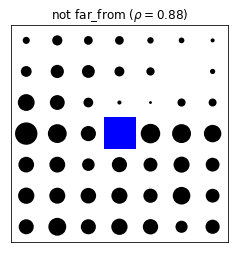

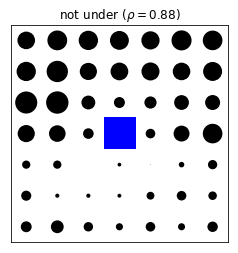

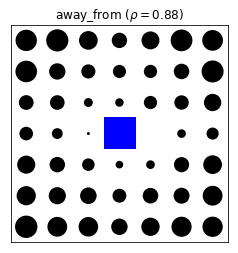

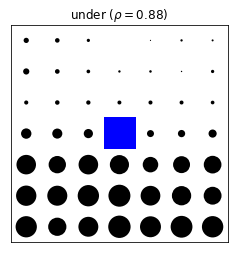

In [37]:
print("Which ones got bad results:")
for sent, corr in results.items():
  # only plot those with
  if corr < 0.4:
    print("rho = {0:0.2f} {1}".format(corr, sent))
        
print("How well model learned templates:")
for sent in impoverishing_policies["excluded_base_templates"]:
  plot_template(restored_templates[sent], title=sent + r" $(\rho={0:.2f})$".format(corr))
  #plot_template(all_templates[sent], title=sent+" (orginal)")
